# Reinforcement Learning assignment: Worm
### Made by Group 23:
- Kaj de Lange, 
- Troy Dijsselbloem, s1145721
- Julian Dinnissen, s1135596
- Sten Nellen, 

In [125]:
import importlib
import numpy as np
import gymnasium as gym

import dp, mc, td
importlib.reload(dp)
importlib.reload(mc)
importlib.reload(td)
from dp import *
from mc import *
from td import *

# Abstract

_insert your abstract here_

# 0. Environment

In [126]:
from environment import MouseEnv
from gymnasium.envs.registration import register

    
register(id="mouse-v0", entry_point="__main__:MouseEnv")


#Create the environment
env = gym.make("mouse-v0")
# Interact with the environment
obs, info = env.reset()
for _ in range(10):
    action = env.action_space.sample() # Random action
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
        print("Game Over!")
        break
env.close()

      ╭───╮
╭─────╯ h │
│ m 0 0 0 │
│ 0 0 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 0 │
│ m 0 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 0 │
│ 0 0 0 c │
│ m 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 0 │
│ m 0 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 0 │
│ 0 m 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 0 │
│ 0 0 m c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 m 0 │
│ 0 0 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 m │
│ 0 0 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 0 m │
│ 0 0 0 c │
│ 0 0 0 0 │
╰─────────╯
      ╭───╮
╭─────╯ h │
│ 0 0 m 0 │
│ 0 0 0 c │
│ 0 0 0 0 │
╰─────────╯


# 1. Introduction

_insert your introduction in this cell_

_describe your environment and the problem the agent has to solve_

_describe the objective of the report (e.g. comparing various RL algorithms) and how you are going to accomplish this (research question)_

_don't forget to add plots/images of the environment, can be done via code cells, but also by inserting .png files into the jupyter notebook_

# 2. Dynamic Programming algorithms

First run the Dynamic Programming algorithms (Policy Iteration and Value Iteration) by calling functions from the separate `dp.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [127]:
# Plotting functions
def plot_convergence(y):
    X = range(len(y))
    plt.plot(X, y)
    plt.yscale("log")
    plt.title("Delta per iteration")
    plt.xlabel("Iterations")
    plt.ylabel("log(Delta)")
    plt.grid()
    
def plot_state_value(Vs: dict):
    values = list(Vs.values())
    bins = 100
    plt.hist(values, bins=bins)
    plt.title("Distribution of state rewards")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")

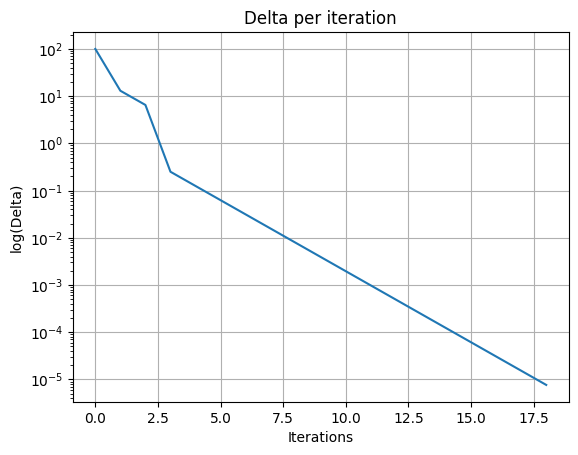

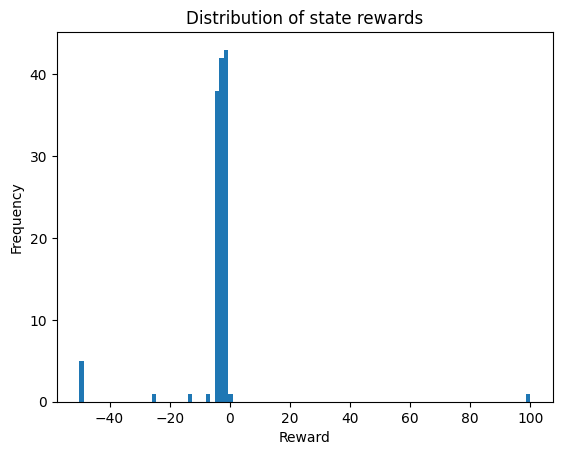

In [128]:
# Evaluating and plotting a policy
env = MouseEnv()
policy = {state: random.randint(0, 3) for state in range(env.num_of_states)}
theta = 1e-5
discount_rate = 0.5
state_value_function, delta_history = evaluate_policy(env=env, policy=policy, theta=theta, gamma=discount_rate)

plot_convergence(delta_history); plt.show()
plot_state_value(state_value_function); plt.show()

In [129]:
# Call Policy Iteration algorithm

In [130]:
# Call Value Iteration algorithm

_In this cell, describe how the algorithms work, how the algorithms differ, plot results and/or policies (add more code cells!), etc._

# 3. Monte Carlo algorithms

First run the Monte Carlo algorithm (Monte Carlo Exploring Starts or Monte Carlo without Exploring Starts (with $\epsilon$-greedy strategy)) by calling functions from the separate `mc.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [131]:
# Call Monte Carlo algorithm

_In this cell, describe how the algorithms work, how the algorithms differ (compared to the one you did not code), plot results and/or policies (add more code cells!), etc._

# 4. Temporal Difference algorithms

First run the Temporal Difference algorithms (SARSA and Q-learning) by calling functions from the separate `td.py` file, and create plots. Then, fill in the cell completing your 'report' within this file.

In [132]:
# Call SARSA algorithm

In [133]:
# Call Q-learning algorithm

# 5. Comparison and discussion

Compare different algorithms (MC and TD with plots). You don’t need to plot DP alongside MC and TD since DP is not a learning algorithm. However, DP can provide the ground truth for optimal state or action values, which can serve as a reference when evaluating MC and TD. You can choose to plot any of the following: cumulative reward, root mean squared error, sample efficiency, or any other metric you think is a fair comparison.

Include a discussion: what can you conclude by comparing different RL algorithms? Do they have certain strengths or limitations?

_Add as many text cells as you like_

In [134]:
# Add as many code cells as you like

# 6. Conclusion

Conclude your project.

_Add as many text cells as you like_